In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Esta versión considera las siguientes variables:
- Variables predictoras: #edad
- Variables de respuesta: Acción, Drama, Romance, Ciencia ficción, Histórica


<font color='gray'>*This version take into account the following variables:*
- *Independent variables:  #edad*
- *Dependent variables:  Acción, Drama, Romance, Ciencia ficción, Histórica*</font>

In [8]:
path = 'datasets/peliculas_a.csv'
peliculas_df = pd.read_csv(path, usecols=[0,4, 5,6,7,8])

# Análisis

<font color='gray'>*Analysis*</font>

,count
#edad,
16,20
17,20
18,23
19,14
20,19
...,...
94,16
95,19
96,24


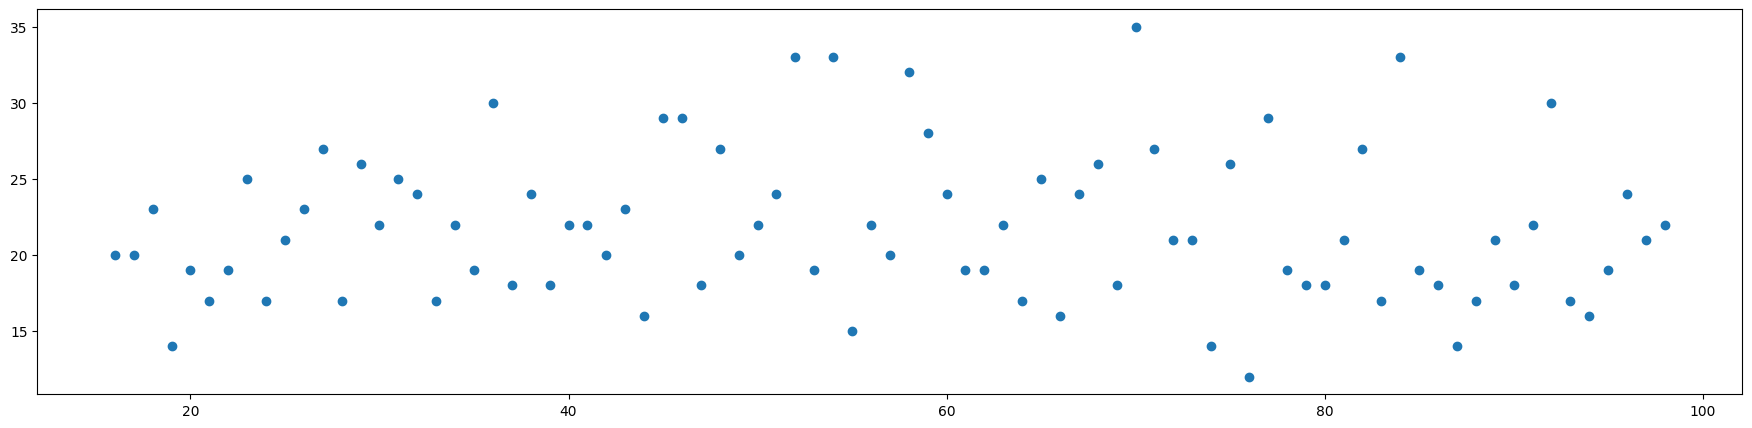

In [20]:
fig_ed, ax_ed = plt.subplots()

freq_edad = peliculas_df[['#edad', 'Acción']].groupby('#edad').count()
freq_edad = freq_edad.rename(columns = {'Acción': 'count'})

ax_ed.scatter(freq_edad.index, freq_edad['count'])
fig_ed.set_size_inches(22,5)
freq_edad

In [21]:
# Son secuencia? (Is it a sequence?)
all(freq_edad.index[:-1] < freq_edad.index[1:])

True

Estos resultados muestran que hay suficientes muestras cada año para agruparlas por año, aunque puede haber algunos "vecinos" de edades cercanas que tengan características similares a las del año en cuestión. Esos podrían estar juntos. También necesitamos "error" por lo que quizás la mejor opción sea la de buscar distribuciones uniformes.

<font color='gray'>*These results show that there are enough samples in each age to suggest to analyze by age. However, there may be some 'neighbors' with closer ages that also have similar features to the ones of the analyzed age. They may be grouped. The model needs a source of 'error' also, so looking for uniform distributions may be preferable.*</font>

## Correlación

<font color='gray'>*Correlation*</font>

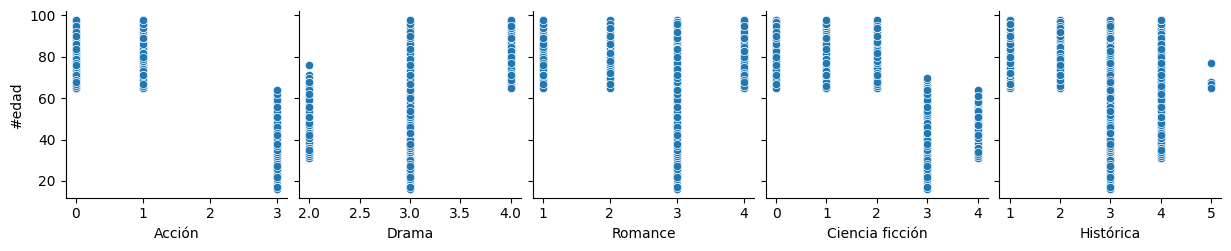

In [23]:
sns.pairplot(data=peliculas_df,
                  x_vars=peliculas_df.columns[1:],
                  y_vars=['#edad'])

<Axes: >

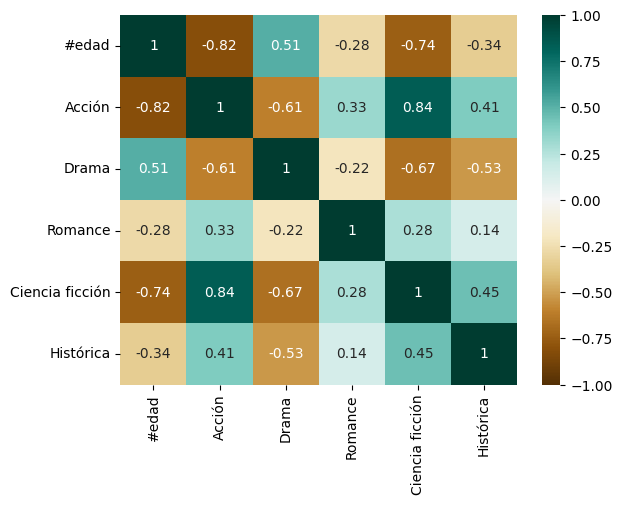

In [25]:
sns.heatmap(peliculas_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

Alta correlación:
- Edad / Acción (negativa)
- Edad / Ciencia Ficción (negativa)
- Acción / Ciencia Ficción (positiva)

Media correlación
- Edad / Drama (positiva)
- Acción / Drama (negativa)
- Acción / Histórica (positiva)
- Ciencia Ficción / Histórica (positiva)

Otras notas:
- Edad / Histórica: Parece no haber correlación, pero parece que los adultos prefieren ver también "menos", mientras que los jovenes si es que ven, ven más.


<font color='gray'>*High correlation:*
- *Edad / Acción (negative)*
- *Edad / Ciencia Ficción (negative)*
- *Acción / Ciencia Ficción (positive)*

*Moderate correlation*
- *Edad / Drama (positive)*
- *Acción / Drama (negative)*
- *Acción / Histórica (positive)*
- *Ciencia Ficción / Histórica (positive)*

*Notes:*
- *Edad / Histórica: Low correlation, but it still seems adults choose to watch 'less' movies, while young people watch more.*</font>

# Metodología

<font color='gray'>*Methodology*</font>

In [26]:
# Let's calculate the probability for each movie genre for the age = 71
peliculas_df[peliculas_df['#edad'] == 71].sum().iloc[1:] / peliculas_df[peliculas_df['#edad'] == 71].sum().iloc[1:].sum()

Acción             0.037594
Drama              0.353383
Romance            0.244361
Ciencia ficción    0.097744
Histórica          0.266917
dtype: float64

In [30]:
peliculas_df[peliculas_df['#edad'] == 71]
# Sorting the genres by probability we end up with (less to more probable):
# Acción | Ciencia Ficción | Romance | Historica | Drama

,#edad,Acción,Drama,Romance,Ciencia ficción,Histórica
37,71,1,3,2,0,3
210,71,0,3,1,0,3
267,71,0,2,4,2,4
291,71,0,3,2,1,4
367,71,0,4,3,1,3
376,71,1,4,3,0,2
440,71,0,3,4,0,2
680,71,1,3,1,2,3
790,71,0,3,1,2,1
829,71,0,3,2,2,2


In [32]:
# checking if the sample #291 matches a given prediction
all(peliculas_df[peliculas_df['#edad'] == 71].loc[291] == pd.Series([71,0,3,2,1,4], index = peliculas_df.columns))

True

Entonces se puede usar la probabilidad de preferencia por un género en una edad específica para ordenar los géneros por relevancia para esa edad.

<font color='gray'>*So the probability of preference for a genre in an specific age could be used to sort the genres by relevance for that age.*</font>

- Calculando para todo el conjunto de datos de entrenamiento

<font color='gray'>*Calculating for the entire training dataset*</font>

In [33]:
# Split sets
X = peliculas_df['#edad']
y = peliculas_df.drop('#edad', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2024)

train_set = y_train.join(X_train, how = 'inner')
test_set = y_test.join(X_test, how = 'inner')

In [34]:
# Calculate the probability of each genre by age
age_groups = train_set.groupby('#edad')
age_t_points = train_set.groupby('#edad').sum().T.sum()

probs_by_age = age_groups.sum().apply(lambda col: col / age_t_points)
probs_by_age

,Acción,Drama,Romance,Ciencia ficción,Histórica
#edad,,,,,
16,0.200000,0.200000,0.200000,0.200000,0.200000
17,0.200000,0.200000,0.200000,0.200000,0.200000
18,0.200000,0.200000,0.200000,0.200000,0.200000
19,0.200000,0.200000,0.200000,0.200000,0.200000
20,0.200000,0.200000,0.200000,0.200000,0.200000
...,...,...,...,...,...
94,0.051724,0.379310,0.206897,0.120690,0.241379
95,0.030769,0.361538,0.261538,0.084615,0.261538
96,0.071429,0.357143,0.203297,0.098901,0.269231


- Veamos si hay probabilidades iguales para algunos géneros.

<font color='gray'>*Let's see if there are equal probabilities for some genres.*</font>

In [35]:
probs_by_age.apply(lambda row: len(row.unique()), axis = 1).sort_values().unique()

array([1, 3, 4, 5], dtype=int64)

Entonces hay casos donde la probabilidad es la misma. Ya que tenemos que ordenar los géneros para entregar una recomendación por relevancia, esto representa un problema. La forma de resolverlo es darse cuenta que se trata de un **preorden total**. Esto quiere decir que puede haber grupos de elementos que están en un nivel más alto que otros grupos en el ordenamiento.

Por ejemplo, la muestra [(0,Acción), (1,Drama), (1,Romance), (0,Ciencia Ficción), (4,Histórica)] puede ser ordenada como [(0,Acción), (0,Ciencia Ficción), (1,Drama), (1,Romance), (4,Histórica)] pero, como se puede ver, sólo hay 3 lugares en este ordenamiento (a saber 0, 1 y 4). Así que podemos considerar equivalentes a géneros en el mismo nivel.

Esto implica la siguiente equivalencia:
- [(0,Acción), (0,Ciencia Ficción), (1,Drama), (1,Romance), (4,Histórica)] = [(0,Ciencia Ficción), (0,Acción), (1,Romance), (1,Drama), (4,Histórica)]

Por lo tanto, ordenar por género después de ordenar por score no cambia el resultado (ya que los usuarios con esas características prefieren de manera igual a esos géneros).

<font color='gray'>*There are actually cases where the probability is the same. Since we have to sort the genres to give a recommendation by relevance, this constitute a problem.*
*The way to solve it is realizing this is a weak ordering. This means there may be groups of elements that are higher in order than other groups.*

*For instance, the sample [(0,Acción), (1,Drama), (1,Romance), (0,Ciencia Ficción), (4,Histórica)] can be ordered as [(0,Acción), (0,Ciencia Ficción), (1,Drama), (1,Romance), (4,Histórica)] but, as can be seen, there's only 3 places in this order (namely 0,1,4). So we could consider genres in the same level to be equally relevant.*

*That implies the following equivalence: *
- [(0,Acción), (0,Ciencia Ficción), (1,Drama), (1,Romance), (4,Histórica)] = [(0,Ciencia Ficción), (0,Acción), (1,Romance), (1,Drama), (4,Histórica)]

Thus, sorting by genre after sorting by score does not change the outcome.</font>

In [37]:
# Case with 2 equal probabilities
probs_by_age[probs_by_age.apply(lambda row: len(row.unique()), axis = 1).sort_values() == 4].head(10)
# In this case, Acción and Romance has the same hierarchy

C:\Users\Jafet Velásquez Luna\AppData\Local\Temp\ipykernel_40120\1528474689.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  probs_by_age[


,Acción,Drama,Romance,Ciencia ficción,Histórica
#edad,,,,,
31,0.191489,0.130699,0.191489,0.234043,0.252280
32,0.194175,0.129450,0.194175,0.223301,0.258900
33,0.192661,0.133028,0.192661,0.229358,0.252294
34,0.194444,0.141975,0.194444,0.222222,0.246914
35,0.193548,0.142857,0.193548,0.225806,0.244240
36,0.193548,0.136476,0.193548,0.225806,0.250620
37,0.194805,0.151515,0.194805,0.220779,0.238095
38,0.195652,0.149068,0.195652,0.217391,0.242236
39,0.194805,0.142857,0.194805,0.220779,0.246753


Así que la metodología es:

- Entrenamiento
1. Calcular la probabilidad de cada género por edad.
2. Asignar un valor entero entre $[0,4]$ a cada género por orden de probabilidad (variable K)
3. Se ordenan los géneros con base en el punto 2 (representante de la clase de equivalencia para cada edad).

- Predicción
1. Se introduce una edad X.
2. Se asigna el representante de la clase de equivalencia de ordneamiento de géneros para X.

- Comprobación
1. Se introduce y_test (Series con index: géneros; valores: scores).
2. Se crea una lista de pares ordenados para cada género -> (score,K).
3. Se ordena por score.
4. Se ordena por K.
5. y_test se transforma en un conjunto de listas de géneros preferidos por los usuario.
6. Se compara el número de casillas correctas por muestra (y_test == y_pred).

**NOTA:** El paso 2 de la comprobación puede parecer que se "añade información", pero en realidad no, ya que el orden de relevania en una muestra se consigue en el paso 3 al ordenar por "score", mientras que el sub-ordenamiento añadido por "K" sólo es una manera conveniente de comparar grupos con la misma jerarquía. Esto permite resolver la diferencia entre el ordenamiento de las casillas en una fila (**orden total**) y el ordenamiento de los géneros (**preorden total**). El resultado sería el mísmo aún si no se incluyera el ordenamiento por "K", pero la comparación (y_test == y_pred) resultaría más complicada.

<font color='gray'>*So the methodology would be:*

- *Training*
1. *Claculating the probability of each genre by age.*.
2. *Set an integer value in $[0,4]$ by probability order to each genre (K variable)*.
3. *Order the genres based on point 2 (it'll be the representative of each age equivalence class)*.

- *Predict*
1. *Input the age X.*
2. *Output the representative of the equivalence class as the list of ordered genres for X*.

- *Testing*
1. *Input y_test (Series with index: genres; values: scores)*.
2. *Make a list of ordered pairs for each genre -> (score,K)*.
3. *Order by score*.
4. *Order by K*.
5. *y_test is transformed into a set of lists of prefered genres*.
6. *Compare the number of correct cells per sample (y_test == y_pred)*.

**NOTE:** The Testing Step 2 may seems to 'add new information', but actually it does not, because the relevance order in a sample is given in the Step 3 by sorting by 'score', while the sub-order appended by "K" is just a convenient means for comparing genre groups with equal hierarchy. This allows it to settle the difference between the cell ordering in a row (total order) and the genre ordering (total preorder). The result would be the same even if the 'K'-ordering were not included, but the comparison (y_test == y_pred) would be tricky.
</font>

# Modelo

<font color='gray'>*Model*</font>

In [47]:
class Recomendador:
    def __init__(self):
        '''Predictions are ordered as:
            0: Less relevant
            4: More relevant'''
        pass

    def fit(self, X_train, y_train):
        '''
        X_train: (Series) Datos de entrenamiento
        y_train: (DataFrame) Etiquetas de los datos de entrenamiento
        
        '''
        self.generos = list(y_train.columns)
        train_set = y_train.join(X_train, how = 'inner')

        # Modelo: probabilidad x grupo
        age_groups = train_set.groupby('#edad')
        age_t_points = train_set.groupby('#edad').sum().T.sum() # total points by genre
        probs_by_age = age_groups.sum().apply(lambda col: col / age_t_points) # PDF
        self.model = probs_by_age
        pass

    def predict(self, X_test):
        '''
        X_test: (iterador) Datos de prueba
        '''
        X_test = pd.Series(X_test)
        # Query the model, sort by probability and returns the ordered list of genres
        y_pred = X_test.apply(lambda age: pd.Series(self.model.loc[age].sort_values().index.values))
        return y_pred

    def score(self, X_test, y_test, y_pred):
        ''' Calcula el valor esperado de casillas correctas de la predicción '''
        test_set = y_test.join(X_test, how = 'inner')
        test_set = test_set.set_index('#edad')

        # Transform scores -> Ordered genre preference (total preorder)
        self.y_test_transf = test_set.apply(lambda sample: self._transform_sample(sample), axis = 1)

        # compare row by row
        comparing_bool = y_pred.reset_index(drop = True) == self.y_test_transf.reset_index(drop = True)
        number_success_df = pd.DataFrame(comparing_bool.apply(lambda row: row.sum(), axis = 1))
        distrib_success = number_success_df.groupby(0).agg({0: len})
        tot_success = distrib_success.sum().sum()

        distrib_success['p'] = distrib_success[0]/tot_success
        distrib_success['px'] = distrib_success['p'] * distrib_success.index
        self.E = distrib_success['px'].sum()
        return {'Esperanza': self.E}

    def _transform_sample(self, test_set):
        ''' transform score list -> total preordered genres list'''
        # test_set (index: edad, cols: generos)

        df_recomendacion = pd.DataFrame([test_set, self.model.loc[test_set.name]], index = ['cal','p']).T
        df_recomendacion = df_recomendacion.sort_values(['cal','p'])
        recomendacion = df_recomendacion.index.values
        return pd.Series(recomendacion)

# Testing

In [44]:
R = Recomendador()
R.fit(X_train,y_train)
y_predict = R.predict(X_test)
y_predict

,0,1,2,3,4
838,Acción,Drama,Romance,Ciencia ficción,Histórica
297,Acción,Ciencia ficción,Romance,Histórica,Drama
597,Drama,Acción,Romance,Ciencia ficción,Histórica
857,Acción,Ciencia ficción,Histórica,Romance,Drama
32,Acción,Ciencia ficción,Romance,Drama,Histórica
...,...,...,...,...,...
1520,Acción,Drama,Romance,Ciencia ficción,Histórica
1105,Acción,Drama,Romance,Ciencia ficción,Histórica
1424,Acción,Ciencia ficción,Romance,Histórica,Drama
736,Drama,Acción,Romance,Ciencia ficción,Histórica


In [45]:
R.score(X_test, y_test, y_predict)

{'Esperanza': 4.320441988950276}

- One more...

In [46]:
R.predict([29])

,0,1,2,3,4
0,Acción,Drama,Romance,Ciencia ficción,Histórica
